# 1- Libraries

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

# 2- Helping Functions

## 2.1 Data preparing:

In [5]:
'''Build a function to convert data into a data frame with 2 columns: label, text,
The function takes the file or the train/test data
and a for loop loops over the text in the file to split texts from labels'''

def process_data(file):
    data = []
    for index, row in file.iterrows():
         # first line data is raw data
        line = row[0]
        
        #split lines into text and labels
        label, text = line.split(' ', 1) 
        
        #remove the __label__ only keep the number
        label = label.replace('__label__', '') 
        
        #append
        data.append((label, text.strip()))
        
    cols = ['label', 'review']
    return pd.DataFrame(data, columns=cols)

## 2.2 Data Cleaning

In [11]:
def text_cleaning(text):
    
    #apply lowercase
    text = text.lower()  
    
    #remove special characters and numbers and extra whitespace
    pattern_punc = r'[^A-Za-z\s]'
    text = re.sub(pattern_punc, '', text).strip()
    return text

In [2]:
train_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'
test_path = '/kaggle/input/amazonreviews/test.ft.txt.bz2'

# 3- Read Data

In [3]:
train_data = pd.read_csv(train_path, compression='bz2', delimiter='\t')
test_data = pd.read_csv(test_path, compression='bz2', delimiter='\t')
print(train_data.head())

  __label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0  __label__2 The best soundtrack ever to anythin...                                                                                                                                                                                                                                                                                                                                                                                                   
1  __label__2 Amazing!: This soundtrack is my fav...                                                                    

##### it's shown that the data consists of 2 parts:
- __label__, text. Therefore we will build a function that separates each part from each other and create a dataframe of 2 columns

In [4]:
print("Train data shape" ,train_data.shape)
print("Test data shape" ,test_data.shape)

Train data shape (3599999, 1)
Test data shape (399999, 1)


In [6]:
train = process_data(train_data)
train.head()

,label,review
0,2,The best soundtrack ever to anything.: I'm rea...
1,2,Amazing!: This soundtrack is my favorite music...
2,2,Excellent Soundtrack: I truly like this soundt...
3,2,"Remember, Pull Your Jaw Off The Floor After He..."
4,2,an absolute masterpiece: I am quite sure any o...


In [7]:
test = process_data(test_data)
test.head()

,label,review
0,2,One of the best game music soundtracks - for a...
1,1,Batteries died within a year ...: I bought thi...
2,2,"works fine, but Maha Energy is better: Check o..."
3,2,Great for the non-audiophile: Reviewed quite a...
4,1,DVD Player crapped out after one year: I also ...


1 is the negative review while 2 is the positive one so we will replace 2 with 1 and 1 with 0

In [8]:
train['label'].value_counts()

label
1    1800000
2    1799999
Name: count, dtype: int64

In [9]:
train['label'] = train['label'].replace({"2":"1", "1":"0"}) #train data
test['label'] = test['label'].replace({"2":"1", "1":"0"}) #test data

In [10]:
print("Count of labels in the train data is:" ,train['label'].value_counts())
print("-"*45)
print("Count of labels in the test data is:" ,test['label'].value_counts())

Count of labels in the train data is: label
0    1800000
1    1799999
Name: count, dtype: int64
---------------------------------------------
Count of labels in the test data is: label
0    200000
1    199999
Name: count, dtype: int64


# 4- Cleaned Data

In [12]:
train['review_cleaned'] = train['review'].apply(text_cleaning)
train.head()

,label,review,review_cleaned
0,1,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything im readin...
1,1,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...
2,1,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...
3,1,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...
4,1,an absolute masterpiece: I am quite sure any o...,an absolute masterpiece i am quite sure any of...


In [13]:
test['review_cleaned'] = test['review'].apply(text_cleaning)
test.head()

,label,review,review_cleaned
0,1,One of the best game music soundtracks - for a...,one of the best game music soundtracks for a ...
1,0,Batteries died within a year ...: I bought thi...,batteries died within a year i bought this ch...
2,1,"works fine, but Maha Energy is better: Check o...",works fine but maha energy is better check out...
3,1,Great for the non-audiophile: Reviewed quite a...,great for the nonaudiophile reviewed quite a b...
4,0,DVD Player crapped out after one year: I also ...,dvd player crapped out after one year i also b...


In [14]:
#print(stopwords.words("english"))

# 5- Tokenization and Padding

In [15]:
max_words = 1000
max_len = 100

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(train['review_cleaned'])

X_train = tokenizer.texts_to_sequences(train['review_cleaned'])
X_test = tokenizer.texts_to_sequences(test['review_cleaned'])

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [16]:
y_train = train['label']
y_test = test['label']

# 6- Data Splitting

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [30]:
X_train = np.array(X_train)
print("Train:", X_train.shape)
y_train = np.array(y_train)
print("Train:", y_train.shape)
print("-"*50)
X_valid = np.array(X_valid)
print("Valid:", X_valid.shape)
y_valid = np.array(y_valid)
print("Valid:", y_valid.shape)
print("-"*50)
X_test = np.array(X_test)
print("Test:", X_test.shape)
y_test = np.array(y_test)
print("Test:", y_test.shape)

Train: (2879999, 100)
Train: (2879999,)
--------------------------------------------------
Valid: (720000, 100)
Valid: (720000,)
--------------------------------------------------
Test: (399999, 100)
Test: (399999,)


In [61]:
y_train = y_train.astype('int')
y_valid = y_valid.astype('int')
y_test = y_test.astype('int')

# 7- LSTM model building

In [85]:
model = Sequential()
model.add(Input(shape=(max_words,), dtype='int32'))
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))  
model.add(LSTM(units=256))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 1000, 128)      │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 1000, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,081 (2.50 MB)

 Trainable params: 654,081 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

# 8- Model Training

In [86]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=2048, verbose=1, validation_data=(X_valid, y_valid))

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 437s 309ms/step - accuracy: 0.8534 - loss: 0.3210 - val_accuracy: 0.9128 - val_loss: 0.2145
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 433s 308ms/step - accuracy: 0.9150 - loss: 0.2104 - val_accuracy: 0.9217 - val_loss: 0.1955
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 434s 308ms/step - accuracy: 0.9231 - loss: 0.1923 - val_accuracy: 0.9252 - val_loss: 0.1874
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 434s 308ms/step - accuracy: 0.9282 - loss: 0.1814 - val_accuracy: 0.9295 - val_loss: 0.1786
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 433s 308ms/step - accuracy: 0.9321 - loss: 0.1727 - val_accuracy: 0.9317 - val_loss: 0.1731
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 434s 308ms/step - accuracy: 0.9349 - loss: 0.1665 - val_accuracy: 0.9329 - val_loss: 0.1701
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 434s 308ms/step - accuracy: 0.9377 - loss: 0.1602 - val_accuracy: 0.9351 - val_loss: 0.1665
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 434s 308ms/step - ac

# 9- Model Evaluation

In [87]:
loss, acc = model.evaluate(X_valid, y_valid)
print("Validation Loss = ", loss)
print("Validation Accuracy = ", acc*100, "%")

22500/22500 ━━━━━━━━━━━━━━━━━━━━ 113s 5ms/step - accuracy: 0.9361 - loss: 0.1644
Validation Loss =  0.16540290415287018
Validation Accuracy =  93.57194304466248 %


In [88]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Loss = ", loss)
print("Test Accuracy = ", acc*100, "%")

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - accuracy: 0.9334 - loss: 0.1712
Test Loss =  0.16684073209762573
Test Accuracy =  93.49598288536072 %


# 10- Classification Report

In [89]:
preds = model.predict(X_test)

threshold = 0.5
pred_labels = (preds >= threshold)
true_labels = y_test

cr = classification_report(true_labels, pred_labels)
print(cr)

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step
              precision    recall  f1-score   support

           0       0.92      0.95      0.94    200000
           1       0.95      0.92      0.93    199999

    accuracy                           0.93    399999
   macro avg       0.94      0.93      0.93    399999
weighted avg       0.94      0.93      0.93    399999



# 11- Confusion Matrix

array([[190546,   9454],
       [ 16562, 183437]])

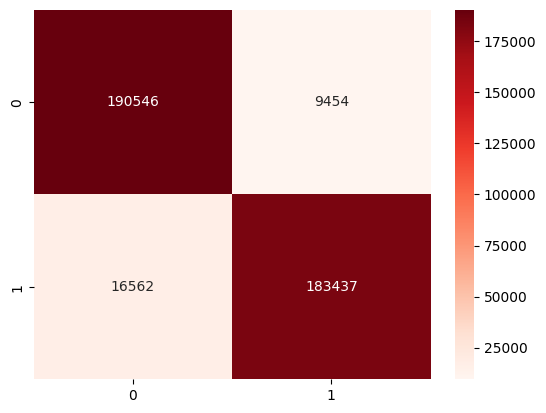

In [90]:
import seaborn as sns
CM = confusion_matrix(y_test, pred_labels)
sns.heatmap(CM, annot = True,fmt='g', cmap='Reds')
CM